# Import bibliotek

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.cm as cm
import pandas_profiling
import plotly

Ustawimy wyświetlanie wykresów w arkuszu jupyter notebook

In [68]:
%matplotlib inline

Jeżeli biblioteki nie działają proponujemy zainstalować je bezpośrednio poprzez jupyter notebook jak poniżej:

In [69]:
!pip install pandas_profiling

# Odpowiednie przygotowanie danych 

## Wczytanie danych

In [70]:
dane_proba = pd.read_csv('../dane/Weather.csv', sep=',')
dane_proba.head()

,Unnamed: 0,city,date,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,...,avg_hg,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,low_wind,precip,events
0,1,Auckland,2016-01-01,2016,1,1,68,65,62,64,...,30.09,30.01,6,6,4,21,15,28.0,0,Rain
1,2,Auckland,2016-01-02,2016,1,2,68,66,64,64,...,29.90,29.80,6,5,1,33,21,46.0,0,Rain
2,3,Auckland,2016-01-03,2016,1,3,77,72,66,70,...,29.73,29.68,6,6,1,18,12,NaN,0,Rain
3,4,Auckland,2016-01-04,2016,1,4,73,66,60,66,...,29.90,29.77,6,6,6,15,10,NaN,0,Rain
4,5,Auckland,2016-01-05,2016,1,5,69,62,55,55,...,30.14,30.09,6,6,6,13,7,NaN,0,NaN


Zauważamy, niepotrzebną kolumnę z numeracją obserwacji. Usuńmy ją.

In [71]:
dane = dane_proba.iloc[:,1:dane_proba.shape[1]]

## Przyjrzyjmy się danym

In [72]:
dane.head()

,city,date,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,avg_dewpt,...,avg_hg,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,low_wind,precip,events
0,Auckland,2016-01-01,2016,1,1,68,65,62,64,60,...,30.09,30.01,6,6,4,21,15,28.0,0,Rain
1,Auckland,2016-01-02,2016,1,2,68,66,64,64,63,...,29.90,29.80,6,5,1,33,21,46.0,0,Rain
2,Auckland,2016-01-03,2016,1,3,77,72,66,70,67,...,29.73,29.68,6,6,1,18,12,NaN,0,Rain
3,Auckland,2016-01-04,2016,1,4,73,66,60,66,60,...,29.90,29.77,6,6,6,15,10,NaN,0,Rain
4,Auckland,2016-01-05,2016,1,5,69,62,55,55,52,...,30.14,30.09,6,6,6,13,7,NaN,0,NaN


### Wyświetlenie etykiet kolumn

In [73]:
dane.columns

Index(['city', 'date', 'year', 'month', 'day', 'high_temp', 'avg_temp',
       'low_temp', 'high_dewpt', 'avg_dewpt', 'low_dewpt', 'high_humidity',
       'avg_humidity', 'low_humidity', 'high_hg', 'avg_hg', 'low_hg',
       'high_vis', 'avg_vis', 'low_vis', 'high_wind', 'avg_wind', 'low_wind',
       'precip', 'events'],
      dtype='object')

### Wyświetlenie typów danych

In [74]:
dane.dtypes

city              object
date              object
year               int64
month              int64
day                int64
high_temp          int64
avg_temp           int64
low_temp           int64
high_dewpt         int64
avg_dewpt          int64
low_dewpt          int64
high_humidity      int64
avg_humidity       int64
low_humidity       int64
high_hg          float64
avg_hg           float64
low_hg           float64
high_vis           int64
avg_vis            int64
low_vis            int64
high_wind          int64
avg_wind           int64
low_wind         float64
precip            object
events            object
dtype: object

Zauważamy, że zmienna precip opisująca ilość opadów z niewiadomego powodu jest typu object, czego zagadka w dalszej części analizy zostanie rozwiązana a problem naprawiony.

### Zliczenie wartości NaN w danych

In [75]:
dane.isna().sum()

city                0
date                0
year                0
month               0
day                 0
high_temp           0
avg_temp            0
low_temp            0
high_dewpt          0
avg_dewpt           0
low_dewpt           0
high_humidity       0
avg_humidity        0
low_humidity        0
high_hg             0
avg_hg              0
low_hg              0
high_vis            0
avg_vis             0
low_vis             0
high_wind           0
avg_wind            0
low_wind         1326
precip              0
events           2217
dtype: int64

W dalszej części analizy przyjrzmy się, co powoduje braki danych i poradzimy sobie z nimi.

### Wyświetlenie wymiaru danych

In [76]:
dane.shape

(3655, 25)

# Rozwiązanie zauważonych problemów z danymi

### Rozwiązanie problemu watości NaN

W kolumnie 'Events' wartość Nan zamieniłyśny na 'No event' - w ten sposób zakodowana jest informacja o braku szczególnych wydarzeń pogodowych

In [77]:
dane['events'] = dane['events'].fillna('No event')

Zamiana NaN w kolumnie dotyczącej pomiaru prędkości wiatru na 0.

In [78]:
dane['low_wind'] = dane['low_wind'].fillna(0)

### Problemy z kolumną 'Precip'

Zauważyłyśmy też, że kolumna 'Precip', dotycząca ilości opadów jest w formacie object, zamiast inf lub float. Przeczytaliśmy opis kolumny. Okazało się, że zawiera ona oznaczenie 'T' na śladową ilość opadów, co może być problemem w dalszej analizie.

Zamiana 'T' (oznacza śladową ilość opadów) w kolumnie dotyczącej opady na niską wartość, niższą od występujących (min 0.007)   ale większą od 0 - wartość 0.001

In [79]:
dane['precip'] = dane['precip'].replace('T', 0.001)

Zmiana typu danych kolumny z ilością opadów oraz zobaczenie statystyk

In [80]:
dane['precip'] = pd.to_numeric(dane['precip'])
dane['precip'].describe()

count    3655.000000
mean        0.080909
std         0.436573
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        12.680000
Name: precip, dtype: float64

### Zmiana nazwy low_wind na max_wind_gust

Ponieważ zauważyłyśmy, że low_wind jest większy od max_wind w wielu kolumnach sprawdziliśmy opis danych. Był on jednak zgodny z opisem kolumn. Sprawdziłyśmy więc źródło danych - była to strona https://www.wunderground.com/history. Ku naszej uciesze istnieją tam dane historyczne. Sprawdziłyśmy dane ze zbioru i okazało się, że dane kolumny low_wind to tak naprawdę dane dotyczące podmuchów wiatru. 

In [81]:
dane.rename(columns={'low_wind': 'max_wind_gust'}, inplace = True)

### Utworzenie kolumn odpowiadającym pojedynczym wydarzeniom

Wyświetlenie unikalnych wartości w kolumnie events

In [82]:
dane['events'].unique()

array(['Rain', 'No event', 'Fog , Rain , Thunderstorm', 'Fog , Rain',
       'Rain , Thunderstorm', 'Rain , Hail', 'Fog', 'Thunderstorm',
       'Rain , Hail , Thunderstorm', 'Snow', 'Rain , Snow',
       'Fog , Thunderstorm', 'Fog , Snow', 'Fog , Rain , Snow',
       'Fog , Snow , Thunderstorm'], dtype=object)

Zobaczenie stosunku danych dla różnych typow zdarzeń

In [83]:
dane.events.value_counts()

No event                      2217
Rain                           910
Rain , Thunderstorm            229
Fog                            115
Snow                            66
Fog , Rain                      44
Thunderstorm                    18
Rain , Snow                     15
Fog , Snow                      12
Fog , Rain , Thunderstorm       10
Rain , Hail                      7
Rain , Hail , Thunderstorm       5
Fog , Rain , Snow                5
Fog , Thunderstorm               1
Fog , Snow , Thunderstorm        1
Name: events, dtype: int64

Widzimy sporą dysproporcję danych, co może utrudniać dalszą analizę.

Niektóre wydarzenia występują tylko raz. W celu więc predykcji zignorujemy ewentualną korelację wydarzeń i osobno przewidzimy każde z nich.

Utworzenie nowych kolumn w celu dekompozycji wydarzeń na pojedyncze oraz późniejszych celów technik uczenia maszynowego

In [84]:
def create(x):
    dane[x] = dane['events']
    dane[x] = [i.find(x) for i in dane[x]]
    dane[x] = dane[x].map({-1: 0}).fillna(1)
    
create("Rain")
create("Fog")
create("Thunderstorm")
create("Snow")
create("Hail")

### Zamiana jednostek na europejskie

Przyglądając się danym zauważyłyśmy także jednostki brytyjskie, do których nie jesteśmy przyzwyczajone i które mogą utrudniać nam zrozumienie danych. Postanowiłyśmy więc je zamienić na bardziej zrozumiałe dla nas i dla pozostałych osób z grupy

Zmiana jednostek temperatury ze stopni K na stopnie C

In [85]:
def convert_to_C(x):
    dane[x] = ((dane[x]-32)*5/9).round(2)
    
for i in ['avg_temp', 'low_temp', 'high_temp', 'avg_dewpt', 'low_dewpt', 'high_dewpt']:
    convert_to_C(i)


Zmiana jednostek odległości z inch na metry.

In [86]:
def convert_to_cm(x):
    dane[x] = (dane[x]*2.54).round(2)
    
for i in ['avg_vis', 'low_vis', 'high_vis']:
    convert_to_cm(i)

Zmiana jednostek wysokości słupa rtęci w calach na hPa.

In [87]:
def convert_to_hpa(x):
    dane[x] = (dane[x]*33.8638).round(2)
    
for i in ['avg_hg', 'low_hg', 'high_hg']:
    convert_to_hpa(i)
    

Zmiana jednostek prędkości wiatru na kilometry na godzinę

In [88]:
def convert_to_kph(x):
    dane[x] = (dane[x]*1.609344).round(2)
    
for i in ['avg_wind', 'max_wind_gust', 'high_wind']:
    convert_to_kph(i)
    

Zmiana jednostek ilości opadów z inch na mm

In [89]:
def convert_to_mm(x):
    dane[x] = (dane[x]*2.54*10).round(2)

convert_to_mm('precip')

### Kontrolne spojrzenie na dane

Zwrócenie 5 pierwszych wierszy (podejrzenie danych)

In [90]:
dane.head()

,city,date,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,avg_dewpt,...,high_wind,avg_wind,max_wind_gust,precip,events,Rain,Fog,Thunderstorm,Snow,Hail
0,Auckland,2016-01-01,2016,1,1,20.00,18.33,16.67,17.78,15.56,...,33.80,24.14,45.06,0.0,Rain,1.0,0.0,0.0,0.0,0.0
1,Auckland,2016-01-02,2016,1,2,20.00,18.89,17.78,17.78,17.22,...,53.11,33.80,74.03,0.0,Rain,1.0,0.0,0.0,0.0,0.0
2,Auckland,2016-01-03,2016,1,3,25.00,22.22,18.89,21.11,19.44,...,28.97,19.31,0.00,0.0,Rain,1.0,0.0,0.0,0.0,0.0
3,Auckland,2016-01-04,2016,1,4,22.78,18.89,15.56,18.89,15.56,...,24.14,16.09,0.00,0.0,Rain,1.0,0.0,0.0,0.0,0.0
4,Auckland,2016-01-05,2016,1,5,20.56,16.67,12.78,12.78,11.11,...,20.92,11.27,0.00,0.0,No event,0.0,0.0,0.0,0.0,0.0


Zobaczenie stosunku obserwacji dla poszczególnych miast

In [25]:
dane.city.value_counts()

Beijing      731
Auckland     731
San Diego    731
Mumbai       731
Chicago      731
Name: city, dtype: int64

Okazuje się, że mamy równą ilość obserwacji z każdego miasta.

# Redukcja wymiaru

### Standaryzacja danych numerycznych (odpowiednich kolumn) - przygotowanie danych do PCA

In [26]:
x = dane.iloc[:, 5:24].values
x = StandardScaler().fit_transform(x)

### Inicjacja odpowiedniej klasy i transformacja danych algorytmem PCA

In [27]:
pca = PCA()
principalComponents = pca.fit_transform(x)

Sprawdzenie, w jakim stopniu poszczególne składowe wyjaśniają wariancję pierwotnych zmiennych

In [28]:
pca.explained_variance_ratio_.cumsum()

array([0.44227753, 0.58839128, 0.72702232, 0.80684514, 0.8564306 ,
       0.90386712, 0.93880518, 0.96071181, 0.97598435, 0.9878244 ,
       0.99161973, 0.99439983, 0.99605524, 0.997494  , 0.99872078,
       0.99961845, 0.99982698, 0.99998367, 1.        ])

W przypadku odcięcia na poziomie 0.8 uwzględnilibyśmy 4 składowe, 0.9 - 6 składowych.

Wykres osypiska - wizualne kryterium ilości istotnych składowych

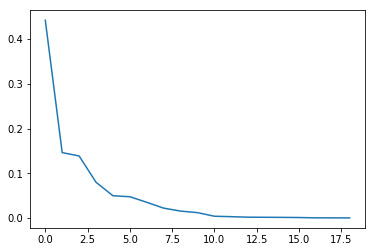

In [29]:
data = pca.explained_variance_ratio_
sns.lineplot(y =data, x = list(range(len(data))))

Patrząc na wykres wybralibyśmy 5 składowych. 

In [30]:
plotly.offline.init_notebook_mode() 
var_exp = pca.explained_variance_ratio_
cum_var_exp = pca.explained_variance_ratio_.cumsum()
trace1 = dict(
    type='bar',
    x=['PC %s' %i for i in range(1,15)],
    y=var_exp,
    name='Wariancja wyjaśniana przez poszczególne składowe'
)

trace3 = dict(
    type='scatter',
    x=['PC %s' %i for i in range(1,15)], 
    y=cum_var_exp,
    name='Skumulowana wyjaśniana wariancja'
)

trace2 = dict(
    type='scatter',
    x=['PC %s' %i for i in range(1,15)], 
    y=var_exp,
    name='Wykres osypiska'
)

data = [trace1, trace2, trace3]

layout=dict(
    title='Wykres osypiska',
    yaxis=dict(
        title='Wyjaśniana wariancja w procentach'
    ),
    legend=dict(x=-.1, y=1.2),
    annotations=list([
        dict(
            x=1.16,
            y=1.05,
            xref='paper',
            yref='paper',
            text='V',
            showarrow=False,
        )
    ])
)

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig) 

### Wizualizacja zbioru danych

Dopasowanie dwóch składowych w celu wizualizacji

In [31]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
                           , columns = ['PC1', 'PC2'])
finalDf = pd.concat([principalDf, dane[['events']], dane[['city']]], axis = 1)

Skumulowana wariancja tłumaczona przez pierwsze dwa komponenty

In [32]:
pca.explained_variance_ratio_.cumsum()

array([0.44227753, 0.58839128])

Jak widzimy dwie składowe słabo wyjaśniają ogólną wariancję zmiennych początkowych. Zastosujemy je więc tylko i wyłącznie w celu wizualizacji zbioru.

Wykres rozrzutu pierwszych dwóch składowych PCA wraz z oznaczeniem wydarzeń

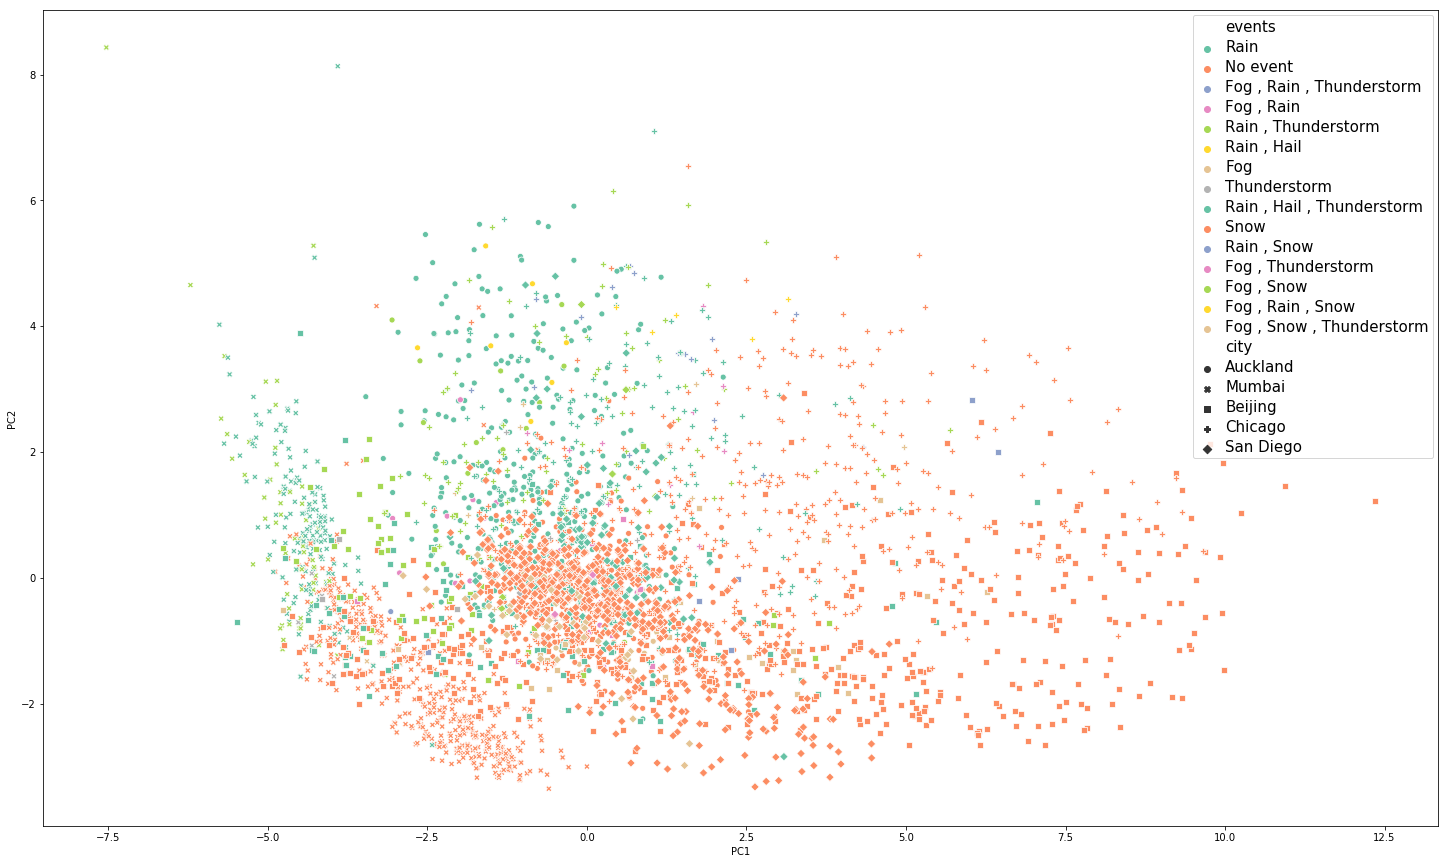

In [33]:
plt.rcParams["figure.figsize"] = (25,15)

fig = sns.scatterplot(data = finalDf, x = 'PC1', y = 'PC2', hue = dane['events'], palette = 'Set2', style = 'city')
plt.setp(fig.get_legend().get_texts(), fontsize='15')
fig

Możemy zaobserwować, że dane nie są liniowo separowalne. Może wynikać to z nakładania się zdarzeń.

Wykres rozrzutu pierwszych dwóch składowych PCA wraz z oznaczeniem miast

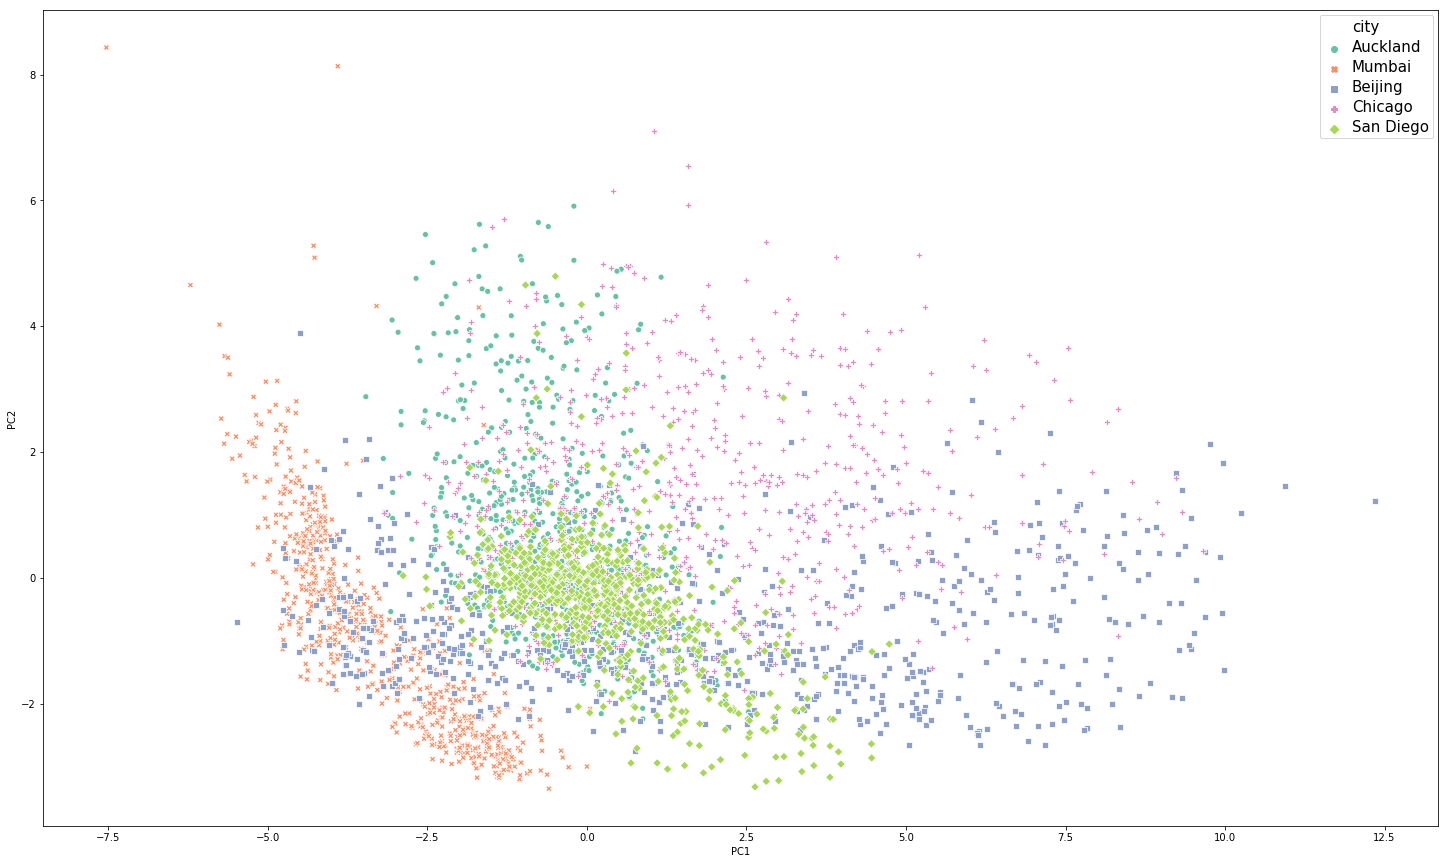

In [34]:
plt.rcParams["figure.figsize"] = (25,15)

fig = sns.scatterplot(data = finalDf, x = 'PC1', y = 'PC2', hue = dane['city'], palette = 'Set2', style = 'city')
plt.setp(fig.get_legend().get_texts(), fontsize='15')
fig

Jak widać dane Mumbaju ewidentnie różnią się od pozostałych. Dane możemy uznać za separowalne według miasta, co daje szansę na sensowną analizę.

# Statystyki

In [39]:
dane.iloc[:,5:24].describe().round(2)[1:]

,high_temp,avg_temp,low_temp,high_dewpt,avg_dewpt,low_dewpt,high_humidity,avg_humidity,low_humidity,high_hg,avg_hg,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,max_wind_gust,precip
mean,21.85,17.36,12.75,13.31,10.55,7.45,85.23,66.46,46.34,1017.29,1014.68,1012.18,20.68,16.91,11.71,26.22,12.01,25.01,2.06
std,9.55,9.26,9.50,9.81,10.61,11.53,13.29,16.93,20.93,7.56,7.43,7.53,11.16,8.95,9.03,10.86,6.22,21.79,11.09
min,-15.00,-17.22,-25.00,-27.22,-31.11,-33.89,24.00,12.00,4.00,992.21,988.82,984.08,3.00,0.00,0.00,6.44,1.61,0.00,0.00
25%,16.67,13.33,8.33,9.44,6.11,2.22,78.00,57.00,30.00,1012.19,1009.82,1007.11,15.00,10.00,3.00,20.92,8.05,0.00,0.00
50%,22.78,18.89,15.00,15.00,12.78,10.00,88.00,70.00,51.00,1016.25,1014.22,1011.85,25.00,15.00,10.00,24.14,9.66,28.97,0.00
75%,30.00,24.44,18.89,19.44,17.22,15.00,94.00,79.00,63.00,1021.33,1018.96,1016.93,25.00,25.00,20.00,32.19,14.48,40.23,0.00
max,38.89,32.22,28.89,30.00,26.67,26.11,100.00,100.00,94.00,1046.73,1044.36,1043.01,48.00,48.00,48.00,206.00,45.06,225.31,322.07


Usunęliśmy nieinformacyjną statystykę count - informowała nas o ilości wierszy dla każdej zmiennej, która jest stała i wynosi tyle co liczba wierszy danych - 3655.

Zauważamy, że średnia temperatura w roku jest dość wysoka. Widocznie są to ciepłe miasta :) Albo statystykę tę zaburzają obserwacje odstające. Widzimy sporą różnicę minimum a pierwszego kwartylem. Może to sugerować, iż są tam obserwacje odstające. Podobnie dla punktu rosy widzimy spore rozbieżności mimnimum a pierwszego kwartyla oraz maksimum a trzeciego kwartyla, wilgotności w przypadku najniższych obserwacji oraz podobnie w przypadku innych zmiennych, przez co podejrzewamy występowanie obserwacji odstających w kolumnach. Możemy zauważyć na tej samej zasadzie wysokie maksimum prędkości wiatru i podmuchów, co sugeruje, że przez któreś miasto przeszła jakaś wichura.

Zobaczmy, ile poszczególnych wydarzeń obserwujemy w konkretnych miastach.

In [ ]:
ggplot(dane, aes(events, fill = events)) +
    geom_bar() +
    facet_wrap(~city) +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())

Pomińmy zamazające obraz brak wydarzeń.

In [ ]:
ggplot(dane[dane.events!='No event'], aes(events, fill = events)) +
    geom_bar() + 
    facet_wrap(~city) +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())

Dodajmy jeszcze statystyki dla poszczególnych miast

In [51]:
for i in pd.unique(dane.city):
    print(i)
    print(dane.iloc[:,5:24][dane.city == i].describe()[1:])

Auckland
      high_temp   avg_temp   low_temp  high_dewpt  avg_dewpt  low_dewpt  \
mean  19.144952  15.898249  12.620410   14.410301  12.370465  10.207483   
std    3.785961   3.644527   3.839296    3.412442   3.542780   3.824059   
min   10.000000   6.110000   1.670000    3.890000   2.220000  -2.220000   
25%   15.560000  13.330000  10.000000   12.220000  10.000000   7.780000   
50%   18.890000  15.560000  12.780000   13.890000  12.220000  10.000000   
75%   22.780000  18.890000  15.560000   17.220000  15.000000  12.780000   
max   27.780000  23.330000  20.560000   22.780000  21.110000  20.000000   

      high_humidity  avg_humidity  low_humidity      high_hg       avg_hg  \
mean      95.228454     80.419973     63.109439  1017.915390  1015.262011   
std        6.124602      7.941573     10.119914     6.841644     7.413184   
min       68.000000     52.000000     32.000000   992.210000   988.820000   
25%       94.000000     75.000000     56.000000  1014.220000  1010.500000   
50%  

Widzimy bardzo dużo wydarzeń typu opadów deszczu w Auckland, jednak patrząc na średnią, musiały być one niewielkie, gdyż wynosi ona 0. Wydaje się to podejrzane, gdyż było ich bardzo wiele a nie mogą być ujemne a średnia jednak, min i max jest równa 0. Sprawdziłyśmy źródło danych i faktycznie był wtedy deszcz, może na tyle niewielki, że zapisano wartość opadów na 0. Postanowiłyśmy w miejscach, gdzie odnotowano jako wydarzenie deszcz a wartość opadów wynosi 0 uznać, że były one znikome i ustawić je na wartość taką samą tak dla oznaczenie 'T'. 

In [93]:
dane.precip = np.where((dane.Rain == 1) & (dane.precip == 0), 0.001, dane.precip)
#dane.dtypes

In [101]:
dane[dane.city=='Auckland'].iloc[:,5:24].describe()[1:]

,high_temp,avg_temp,low_temp,high_dewpt,avg_dewpt,low_dewpt,high_humidity,avg_humidity,low_humidity,high_hg,avg_hg,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,max_wind_gust,precip
mean,19.144952,15.898249,12.620410,14.410301,12.370465,10.207483,95.228454,80.419973,63.109439,1017.915390,1015.262011,1012.837743,1.524000e+01,15.104487,11.622845,28.736854,15.541081,11.652969,0.000622
std,3.785961,3.644527,3.839296,3.412442,3.542780,3.824059,6.124602,7.941573,10.119914,6.841644,7.413184,8.056632,1.759797e-13,0.791689,4.674591,9.852939,7.680992,23.565501,0.000485
min,10.000000,6.110000,1.670000,3.890000,2.220000,-2.220000,68.000000,52.000000,32.000000,992.210000,988.820000,984.080000,1.524000e+01,2.540000,0.000000,9.660000,3.220000,0.000000,0.000000
25%,15.560000,13.330000,10.000000,12.220000,10.000000,7.780000,94.000000,75.000000,56.000000,1014.220000,1010.500000,1007.110000,1.524000e+01,15.240000,7.620000,22.530000,9.660000,0.000000,0.000000
50%,18.890000,15.560000,12.780000,13.890000,12.220000,10.000000,100.000000,81.000000,63.000000,1017.950000,1015.910000,1014.220000,1.524000e+01,15.240000,15.240000,27.360000,14.480000,0.000000,0.001000
75%,22.780000,18.890000,15.560000,17.220000,15.000000,12.780000,100.000000,86.000000,68.000000,1023.030000,1020.320000,1017.950000,1.524000e+01,15.240000,15.240000,34.605000,20.920000,0.000000,0.001000
max,27.780000,23.330000,20.560000,22.780000,21.110000,20.000000,100.000000,100.000000,94.000000,1036.230000,1034.200000,1033.180000,1.524000e+01,15.240000,15.240000,75.640000,45.060000,99.780000,0.001000


Boxplot

In [36]:
from ggplot import *

ggplot(aes(y='avg_temp', x = 'city'), data = dane) + geom_boxplot() # geom_violin()
#ggplot(aes(y='avg_wind', x = 'city'), data = dane) + geom_boxplot()
#ggplot(aes(y='precip', x = 'city'), data = dane) + geom_boxplot()
#ggplot(aes(y='avg_temp', x = 'month'), data = dane) + geom_boxplot()
#ggplot(aes(y='avg_temp', x = 'events'), data = dane) + geom_boxplot()
#vis, dewpt,huminidy


AttributeError: module 'pandas' has no attribute 'tslib'

In [ ]:
sns.set(style="whitegrid")

sns.boxenplot(x="city", y="avg_temp",
              color="b", 
              scale="linear", data=dane)

Możemy ewidentnie zaobserwować występowanie minimum dwóch obserwacji odstających

In [ ]:
#histogramy

Korelacja liniowa cech

In [ ]:
dane.iloc[:,5:25].corr()

In [ ]:
import plotly.tools as tls
plt.figure(figsize= (10,10), dpi=100)
fig=sns.heatmap(dane.iloc[:,5:25].corr())

In [ ]:
import plotly 
plotly.tools.set_credentials_file(username='iza08.ik', api_key='lr02By0LM9Ofjctmhc3T')

import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=dane.iloc[:,5:25].corr())
data=[trace]
py.iplot(data, filename='basic-heatmap')

Raport

In [ ]:
pandas_profiling.ProfileReport(dane)

Możemy zauważyć wykrytą dużą korelację niektórych zmiennych. Wynika to de facto z opisywania tych samych czynników np średnia temperatura oraz najwyższa i najniższa temperatura

# Zapisanie danych do pliku w celu późniejszej analizy

In [ ]:
dane.to_csv('../dane/dane.csv', index = False)


Pomysły: 

analiza szeregu czasowego, 

klasyfikacja, drzewo klasyfikacyjne
tsne z animacją, 

obserwacje odstające, 

post-hoc, anova

wykresy, gęstości wykres

przenieść problem z rainem 